Patrick Gray (patrick.c.gray at duke) - https://github.com/patrickcgray

Adapted from https://github.com/ceholden/open-geo-tutorial


Chapter 1: Exploring rasterio
==========================================

## Introduction

GDAL - the Geospatial Data Abstraction Library is a software library for reading and writing raster and vector geospatial data formats and forms the basis of most software for processing geospatial data.

There are many formats for using GDAL ranging from graphical tools like ArcGIS or QGIS to command line GDAL tools but here we're using the fantastic rasterio python package which provides a pythonic wrapping around GDAL. Basically it reads and writes geospatial formats and provides a Python API based on Numpy N-dimensional arrays and GeoJSON.

One of the most fundamental components of the GDAL raster library is a "[class](https://en.wikipedia.org/wiki/Class_(computer_programming))", or an object, that stores all of the information one might want about a raster image. This class, the `GDALDataset`, combines the information about a raster file with a few actions one might want to perform with a raster image, like reading from an image. The information stored by a class is generally referred to as "[properties](https://en.wikipedia.org/wiki/Property_(programming))" or attributes and the actions a class can perform are called "[methods](https://en.wikipedia.org/wiki/Method_(computer_programming))".

If you're coming from another language and want an overview of object oriented programming in Python, see the [Python tutorial on classes](https://docs.python.org/3/tutorial/classes.html) or the [LearnPython class tutorial](http://www.learnpython.org/en/Classes_and_Objects).

For those wishing for a verbose, full reference to the the GDAL "Application Programming Interface" ([API](http://en.wikipedia.org/wiki/Application_programming_interface)), you can find the C and Python API here:

- [C API](http://gdal.org/python/osgeo.gdal.Dataset-class.html)
- [Python API](http://gdal.org/python/osgeo.gdal.Dataset-class.html)


Some class methods include:

- `GetDriver`
- `GetRasterBand`
- `GetGeoTransform`
- `GetProjection`
- `GetSubDatasets`

These class methods are so called "getter" methods that allow you to access class attributes (remember: class attributes are just variables that belong to the class). When you call the class method, `GetDriver`, the GDAL dataset will return the image format driver (e.g., ENVI driver, GeoTIFF driver, HDF driver) responsibile for handling the input and output operations for this raster file format. Similarly, the `GetGeoTransform` method will the transformation that can be used to translate between pixel coordinates and projection coordinates.

> Note: the "getter" and "setter" class methods for accessing and settting class properties is not "Pythonic" - these methods exist because the API was originally written for C++ where such methods are normal.
    
Another suite of class methods allow you to set class attributes. These include:

- `SetGeoTransform`
- `SetProjection`

which allow you to modify the geographic projection and location of the image.

## Module import in Python

Now that we've seen some of how the GDALDataset object encapsulates many of the ideas relevant to the concept of a raster image, let's see how we can implement these ideas in Python.

Before we can get started, we need to tell Python that we will be using functions, classes, and variables from the GDAL Python package. The technical wording for this is that we need to import the GDAL module into our [namespace](http://en.wikipedia.org/wiki/Namespace) (see Python's documentation on the `module` system [here](https://docs.python.org/2/tutorial/modules.html)).

We will do this using some `import` statements:

In [1]:
import rasterio     # import the main rasterio function
import matplotlib   # matplotlib is the primary python plotting and viz library
# this bit of magic allows matplotlib to plot inline ina  jupyter notebook
%matplotlib inline  
import folium       # folium is an interactive mapping library


# We can check which version we're running by printing the "__version__" variable
print("rasterio's version is: " + rasterio.__version__)
print(rasterio)

rasterio's version is: 1.0.13
<module 'rasterio' from '/opt/conda/envs/geo_env/lib/python3.6/site-packages/rasterio/__init__.py'>


Once we import these packages Python will know where to look on our system for the code that implements them. When we want to access classes, variables, or functions within these packages, we will need to reference the full path (e.g. `rasterio.open()`)

### Examples
#### Open an image
When we open an image in rasterio we create a Dataset object. As the name would suggest, we can open an image with the "open" function within `rasterio`.

We will use an example image provided in this repository for this chapter. This image is a subset of a Landsat 7 image containing the 7 bands on this sensor rearranged in order of wavelength (e.g., Landsat 7's second SWIR channel comes before thermal channel in our stack). The last band in this image is a cloud and cloud shadow mask from Fmask.

In [100]:
# Open a geospatial dataset
img_fp = '../../example/RGB.byte.tif'

from rasterio.plot import show
from rasterio import plot
import matplotlib.pyplot as plt

dataset = rasterio.open(img_fp)
print(dataset)

<open DatasetReader name='../../example/RGB.byte.tif' mode='r'>


Now that we have this dataset open, let's explore some of its capabilities.

#### Image attributes

In [68]:
# what is the name of this image
img_name = dataset.name
print('Image filename: {n}\n'.format(n=img_name))

# How many bands does this image have?
num_bands = dataset.count
print('Number of bands in image: {n}\n'.format(n=num_bands))

# How many rows and columns?
rows, cols = dataset.shape
print('Image size is: {r} rows x {c} columns\n'.format(r=rows, c=cols))

# Does the raster have a description or metadata?
desc = dataset.descriptions
metadata = dataset.meta

print('Raster description: {desc}\n'.format(desc=desc))

# What driver was used to open the raster?
driver = dataset.driver
print('Raster driver: {d}\n'.format(d=driver))

# What is the raster's projection?
proj = dataset.crs
print('Image projection:')
print(proj, '\n')

# What is the raster's "geo-transform"
gt = dataset.transform

print('Image geo-transform:\n{gt}\n'.format(gt=gt))

print('All raster metadata:')
print(metadata)
print('\n')

Image filename: ../../example/RGB.byte.tif

Number of bands in image: 3

Image size is: 718 rows x 791 columns

Raster description: (None, None, None)

Raster driver: GTiff

Image projection:
+init=epsg:32618 

Image geo-transform:
| 300.04, 0.00, 101985.00|
| 0.00,-300.04, 2826915.00|
| 0.00, 0.00, 1.00|

All raster metadata:
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 791, 'height': 718, 'count': 3, 'crs': CRS({'init': 'epsg:32618'}), 'transform': Affine(300.0379266750948, 0.0, 101985.0,
       0.0, -300.041782729805, 2826915.0)}




The first few pieces of information we obtained are fairly straightforward - image name, the raster size, the number of bands, a description, some metadata, and the raster's file format.

The image's projection is formatted in what's known as "Well Known Text". For more information on specific projections and for format conversions among projection description formats (e.g., proj4 string, WKT, ESRI WKT, JSON, etc.) see [Spatial Reference](http://www.spatialreference.org).

The last piece of information we accessed is something called a "geotransform". This set of 6 numbers provides all the information required to and from transform pixel and projected coordinates. In this example, the first number (462405) and the fourth number (1741815) are the top left of the upper left pixel of the raster. The pixel size in x and y dimensions of the raster is listed as the second (30) and the sixth (-30) numbers. Since our raster is north up oriented, the third and fifth numbers are 0. For more information on the GDAL data model, [visit this web page](http://www.gdal.org/gdal_datamodel.html).

### Image raster bands

##### now for the fun part, actually visualizing and working with the data

The rasterio Dataset object we created contains a lot of useful information but it is not directly used to read in the raster image. Instead we will need to access each of the raster's bands individually using the `read()` method:

In [96]:
# Open the red band in our image
red = dataset.read(1)

When we load our raster band into memory we will read it into a [NumPy](http://www.numpy.org/) 2 dimensional array. NumPy is, ["the fundamental package for scientific computing with Python"](http://www.numpy.org/), because it allows us to represent our data in a very memory efficient way.

NumPy arrays are the cornerstone or building block of the rest of the Scientific Python suite of software. Get familiar with them:

+ [NumPy for MATLAB users](http://wiki.scipy.org/NumPy_for_Matlab_Users)
+ [NumPy tutorial](http://wiki.scipy.org/Tentative_NumPy_Tutorial)
+ [NumPy API reference manual](http://docs.scipy.org/doc/numpy/reference/)

Just as we made the routines and data types from rasterio available to us using `import`, we loaded up NumPy. When we import NumPy, we also gave it an alias so that we don't have to type `numpy` every time we want to use it.

In [99]:
# No alias
import numpy
print(numpy.__version__)

# Alias or rename to "np" -- a very common practice
import numpy as np
print(np.__version__)

1.15.4
1.15.4


In [106]:
# What are the band's datatypes?
datatype = dataset.dtypes
print('Band datatypes: {dt}'.format(dt=datatype))

# How about some band statistics?
band_mean = np.mean(red)
band_min = np.amin(red)
band_max = np.amax(red)
band_stddev = np.std(red)
print('Band range: {minimum} - {maximum}'.format(maximum=band_max,
                                                 minimum=band_min))
print('Band mean, stddev: {m}, {s}\n'.format(m=band_mean, s=band_stddev))

Band datatypes: ('uint8', 'uint8', 'uint8')
Band range: 0 - 255
Band mean, stddev: 29.94772668847656, 52.340921626611006



The method `read()` takes arguments that allow us to specify a subset of the raster bands, specific X and Y offsets and sizes of the bands and much more. Remember this ability when you want to process large images or are working with a limited amount of memory. In these circumstances, you will run out of memory if you read the entire dataset in at once. Instead, read in a block of some number of columns and rows at one time, perform your computation and store your output, and then chunk through the rest of the image.

Read more here: https://rasterio.readthedocs.io/en/latest/api/rasterio.io.html#rasterio.io.BufferedDatasetWriter.read

For now, we'll just read in and display the entire image:

In [107]:
full_img = dataset.read()

With our data read into a NumPy array, we can print it to console and even perform statistics on it. In addition to helping us store massive amounts of data efficiently, NumPy will help us with some basic linear algebra, numerical operations, and summary statistics.

Image dimensoions:  (3, 718, 791)


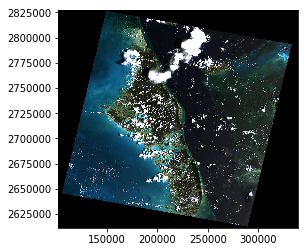

In [105]:
print("Image dimensoions: ", full_img.shape)
show(full_img, transform=dataset.transform)
plt.show()

## Now for some more visualizations

### displaying all three bands side by side

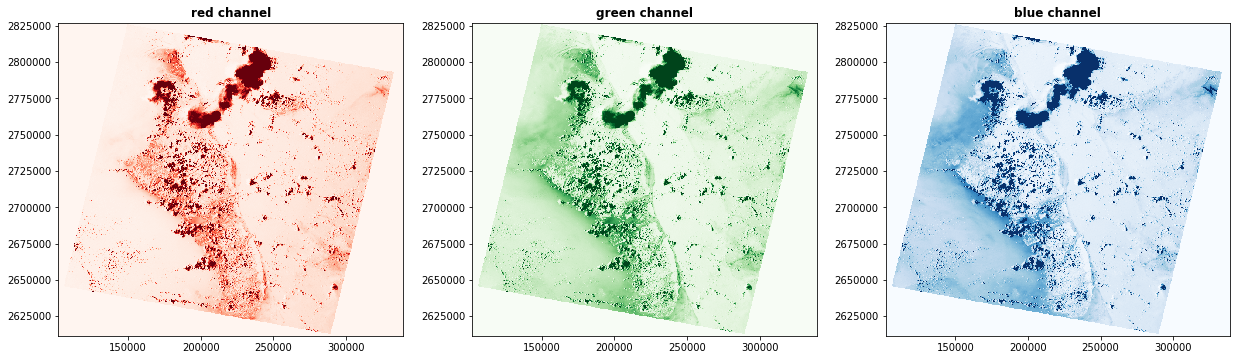

In [109]:
fig, (axr, axg, axb) = plt.subplots(1,3, figsize=(21,7))
plot.show((dataset, 1), ax=axr, cmap='Reds', title='red channel')
plot.show((dataset, 2), ax=axg, cmap='Greens', title='green channel')
plot.show((dataset, 3), ax=axb, cmap='Blues', title='blue channel')

### How about the same thing but with the ability to navigate simultaneously?

<IPython.core.display.Javascript object>


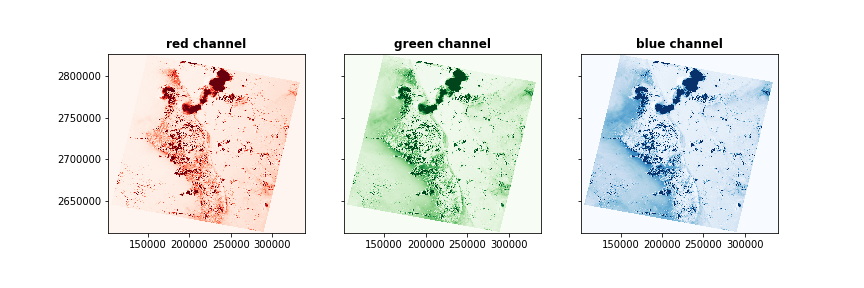

In [38]:
%matplotlib notebook
fig, (axr, axg, axb) = plt.subplots(1,3, figsize=(12, 4), sharex=True, sharey=True)
plot.show((dataset, 1), ax=axr, cmap='Reds', title='red channel')
plot.show((dataset, 2), ax=axg, cmap='Greens', title='green channel')
plot.show((dataset, 3), ax=axb, cmap='Blues', title='blue channel')

### If we want to see a histogram of the data we use the plot.show_hist function

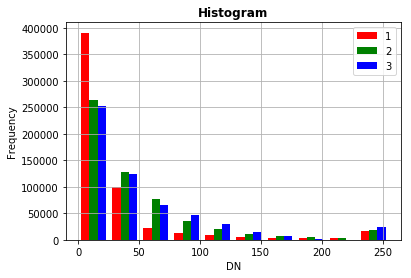

In [103]:
%matplotlib inline
plot.show_hist(dataset)

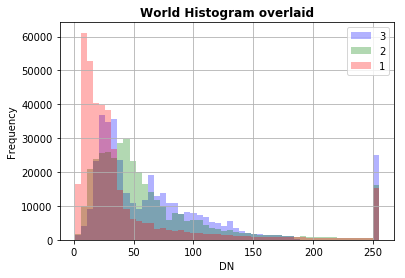

In [41]:
plot.show_hist(dataset, bins=50, lw=0.0, stacked=False, alpha=0.3, 
               histtype='stepfilled', title="World Histogram overlaid")

### Let's look at another raster

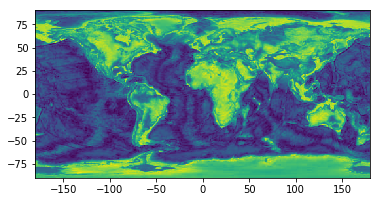

In [63]:
world = rasterio.open("../../example/world.rgb.tif")
plot.show((world), cmap='viridis')

### in this one we can also easily show contours from a raster

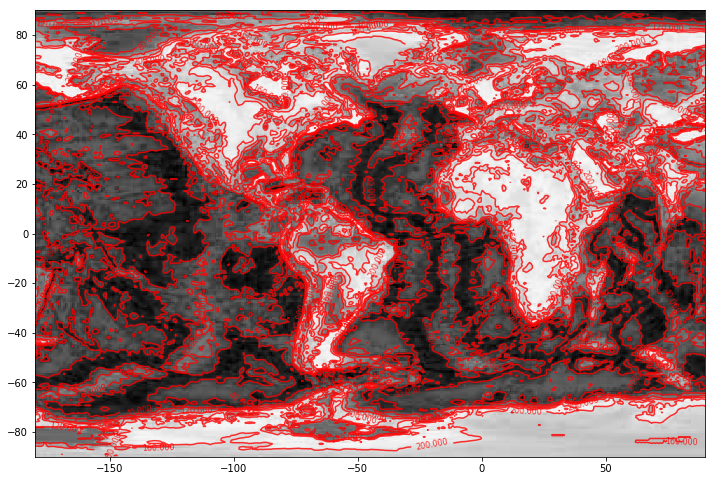

In [64]:
fig, ax = plt.subplots(1, figsize=(12, 12))
plot.show((world, 1), cmap='Greys_r', interpolation='none', ax=ax)
ax.set_xlim(-180, 90)
ax.set_ylim(-90, 90)

plot.show((world, 1), contour=True, ax=ax)

The next chapter (link to [webpage](chapter_2_indices.html) or [Notebook](chapter_2_indices.ipynb)) puts these lessons to use in order to calculate the Normalized Difference Vegetation Index (NDVI).

One key concept to understand as we move on is how to de-allocate memory within Python.

In order to close out your GDAL datasets and to signal that your NumPy arrays can be de-allocated, you can set them to `None`:

In [ ]:
dataset = None

full_img = None
world= None